# Analysis of the Vendors for Craig's Design and Landscaping Services  

## Description 
This notebook reads in an Excel file containing the Vendors for a fictitious company that Intuit made up to show how the Quickbooks data can be exported.


## Data Preparation  

### Code to read in the data

In [1]:
import pandas as pd
#import numpy as np
import re # Regular expressions for dealing with text processing
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

vr = pd.read_excel('VendorsRaw.xlsx') # vr stands for vendorsRaw

### Code to change column Names

In [2]:
v = vr.copy()
v.columns = v.iloc[3,]
v = v.iloc[4:v.shape[0]-3,1:]
v = v.rename(columns = lambda x: re.sub(' ', '', x))
v.rename(columns = {'Account#': 'AccountNum'}, inplace = True)

### Code to create a column for each of the three phone numbers: phone, fax, mobile

In [3]:
# Create blank columns
pnums = v['PhoneNumbers']
pnums = pnums.str.split('\n', n = 3, expand = True)
pnums.columns = ['one', 'two', 'three']
v2 = pd.concat([v, pnums], axis = 1)
v2.reset_index(inplace = True)

# Phone
v2['phone'] = ''
def phone(row):
    if str(row['one']) != 'nan' and re.search('Phone', str(row['one'])) is not None:
        return re.sub('Phone: ', '', row['one'])
    elif str(row['two']) != 'nan' and re.search('Phone', str(row['two'])) is not None:
        return re.sub('Phone: ', '', row['two'])
    elif str(row['three']) != 'nan' and re.search('Phone', str(row['three'])) is not None:
        return re.sub('Phone: ', '', row['three'])
    
v2['phone'] = v2.apply(phone, axis = 1)
# Fax
v2['fax'] = ''
def fax(row):
    if str(row['one']) != 'nan' and re.search('Fax', str(row['one'])) is not None:
        return re.sub('Fax: ', '', row['one'])
    elif str(row['two']) != 'nan' and re.search('Fax', str(row['two'])) is not None:
        return re.sub('Fax: ', '', row['two'])
    elif str(row['three']) != 'nan' and re.search('Fax', str(row['three'])) is not None:
        return re.sub('Fax: ', '', row['three'])
    
v2['fax'] = v2.apply(fax, axis = 1)
# Mobile
v2['mobile'] = ''
def mobile(row):
    if str(row['one']) != 'nan' and re.search('Mobile', str(row['one'])) is not None:
        return re.sub('Mobile: ', '', row['one'])
    elif str(row['two']) != 'nan' and re.search('Mobile', str(row['two'])) is not None:
        return re.sub('Mobile: ', '', row['two'])
    elif str(row['three']) != 'nan' and re.search('Mobile', str(row['three'])) is not None:
        return re.sub('Mobile: ', '', row['three'])
    
v2['mobile'] = v2.apply(mobile, axis = 1)
v2.drop(columns = ['one', 'two', 'three', 'PhoneNumbers'], inplace = True)

### Code to separate the FullName column into three different columns

In [4]:
# Add a blank column for each part of the name
v3 = v2.copy() 
nameCols = ['title', 'firstName', 'middleName', 'lastName', 'suffix']
for i in nameCols:
    v3[i] = ''

# Function to separate out the name
def sepNames(row):
    tempName = str(row['FullName'])
    if tempName not in ['None', 'nan']:
        # Title
        if re.search('\. ', tempName) is not None:
            title = re.sub('\. .*$', '.', tempName)
            tempName = re.sub(title + ' ', '', tempName)
        else:
            title = ''
        # First name
        firstName = re.sub(' .*$', '', tempName)
        tempName = re.sub('^.*'+firstName+' ', '', tempName)
        # Middle
        middleNameEnd = re.search(' ', tempName)
        if middleNameEnd is not None:
            if middleNameEnd.start() <= 2:
                middleName = tempName[0:middleNameEnd.start()]
                tempName = tempName[middleNameEnd.start()+1:]
            else:
                middleName = ''
        else:
            middleName = ''
        # Suffix
        if re.search(' ', tempName) is not None:
            suffix = re.sub('^.* ', '', tempName)
            tempName = re.sub(' .*$', '', tempName)
        else:
            suffix = ''
        # Last Name
        lastName = tempName
    else:
        title, firstName, middleName, lastName, suffix = ['', '', '', '', '']
    return pd.Series([title, firstName, middleName, lastName, suffix])

#v3.loc[24,nameCols] = sepNames(v3.loc[24,]) # Test one row
v3[nameCols] = v3.apply(sepNames, axis = 1)
v3.drop('FullName', axis = 1, inplace = True)

### Code to separate the Address column into separate fields for each part of the address

In [5]:
v4 = v3.copy()
addressCols = ['street', 'city', 'state', 'zip5', 'country']
for i in addressCols:
    v4[i] = ''

def sepAddress(row):
    tempAd = str(row['Address'])
    if tempAd not in ['None', 'nan']:
        #country
        if len(re.findall('\n', tempAd)) > 1:
            country = re.subn('.*\n', '', tempAd)[0]
            tempAd = re.sub('\n.*$', '', tempAd)
        else:
            country = ''
        #street
        street = re.sub('\n.*$', '', tempAd)
        tempAd = re.sub('^.*\n', '', tempAd)
        #zip5
        zip5 = str(tempAd[-5:])
        tempAd = tempAd[:-6]
        #state
        state = tempAd[-2:]
        tempAd = tempAd[:-3]
        #city
        city = tempAd
    else:
        street, city, state, zip5, country = ['', '', '', '', '']
    return pd.Series([street, city, state, zip5, country])
v4[addressCols] = v4.apply(sepAddress, axis = 1)
v4.drop(columns = 'Address', axis = 1, inplace = True)

___
## Create a dataframe for cluster analysis

In [6]:
v5 = v4.copy()
v5 = v5.assign(
        fax = lambda dataframe: dataframe['fax'].map(lambda fax: 1 if fax is not None else 0)
        ).assign(
        lastName = lambda dataframe: dataframe['lastName'].map(lambda lastName: 1 if lastName is not '' else 0)
                ).assign(
                        state = lambda dataframe: dataframe['state'].map(lambda state: state if state is not '' else None)
                        )
v5 = v5[['Vendor', 'fax', 'lastName', 'state']]
# One hot encode the state
v5 = pd.get_dummies(v5, prefix_sep = '_', columns = ['state'])

### Elbow plot to identify the optimal number of clusters

In [7]:
# Magic to show plots inline
%matplotlib inline

Text(0, 0.5, 'WCSS')

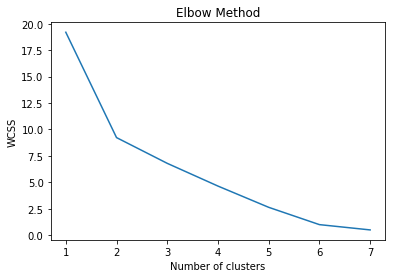

In [8]:
rowLabel = v5['Vendor']
clusterData = v5.drop(columns = 'Vendor', axis = 1)
wcss = [] # within cluster sum of squares

for i in range(1,8):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300
                    , n_init = 10, random_state = 0)
    kmeans.fit(clusterData)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 8), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

### Create clusters

In [9]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300
                    , n_init = 10, random_state = 0)
clusterLabel = kmeans.fit_predict(clusterData)

### Evaluate clusters

In [10]:
# Add cluster labels to dataframe
v5['cluster'] = clusterLabel
# Get centroid values from original data
clusterSum = v5.groupby(['cluster']).mean()
clusterSumT = clusterSum.T
clusterSumT['Feature'] = clusterSumT.index
clusterSumT.rename(columns = {0: 'Cluster_1', 1: 'Cluster_2', 2: 'Cluster_3'}, inplace = True)
clusterSumT

cluster,Cluster_1,Cluster_2,Cluster_3,Feature
fax,0.000000,0.090909,1.0,fax
lastName,0.833333,0.000000,1.0,lastName
state_AZ,0.000000,0.181818,0.0,state_AZ
state_CA,0.833333,0.000000,1.0,state_CA
state_NJ,0.083333,0.000000,0.0,state_NJ


In [11]:
# Cluster centroid values from model fit
clusterCentroids = pd.DataFrame(kmeans.cluster_centers_.T
                                , columns = ['Cluster_1', 'Cluster_2', 'Cluster_3'])
clusterCentroids['Feature'] = clusterSum.columns.values.tolist()
clusterCentroids

,Cluster_1,Cluster_2,Cluster_3,Feature
0,2.775558e-17,9.090909e-02,1.0,fax
1,8.333333e-01,0.000000e+00,1.0,lastName
2,1.387779e-17,1.818182e-01,0.0,state_AZ
3,8.333333e-01,0.000000e+00,1.0,state_CA
4,8.333333e-02,6.938894e-18,0.0,state_NJ


### Plot centroid values

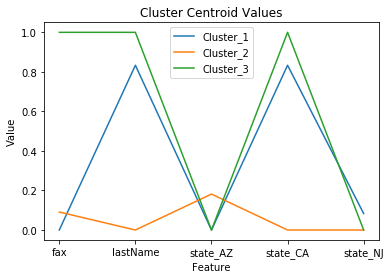

In [12]:
plt.plot('Feature', 'Cluster_1', data = clusterCentroids, label = 'Cluster_1')
plt.plot('Feature', 'Cluster_2', data = clusterCentroids, label = 'Cluster_2')
plt.plot('Feature', 'Cluster_3', data = clusterCentroids, label = 'Cluster_3')
plt.title('Cluster Centroid Values')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend()

## Discussion

The cluster pattern closely resembles the clusters that were formed using the Excel macro:

1. Cluster 3 includes all vendors with a fax number, a contact, and that are in the state of California.
2. Cluster 2 includes the remaining vendors (without a fax number) that have a contact and that are mostly in the state of California. There appears to be some exceptions here, though. About 18% of the vendors in cluster 2 do not have a contact, and about 8% that are in the state of New Jersey.
3. Cluster 1 includes everything else, and is much more heterogeneous in its makeup (i.e., there are a variety of states, vendors with a contact, and vendors with a fax number.